In [1]:
import sys
import os
import h5py
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

# Add AENeAS tools to the path
sys.path.append('/rds/projects/t/themendr-j-brown/aeneas_2.0/aeneas')
from aeneas.denGrid import aeneas2dg, dengrid

# ----------------------------
# Station locations
# ----------------------------
ionosonde_stations = [
    {"name": "ALPENA", "lat": 45.07, "lon": -83.56},
    {"name": "EIELSON", "lat": 64.66, "lon": -147.07},
    {"name": "FAIRFORD", "lat": 51.70, "lon": -1.50},
    {"name": "IDAHO", "lat": 43.81, "lon": -112.68},
    {"name": "JULIUSRUH", "lat": 54.60, "lon": 13.40},
    {"name": "MOSCOW", "lat": 55.49, "lon": 37.29},
    {"name": "TROMSO", "lat": 69.60, "lon": 19.20},
]

# ----------------------------
# File locations and time setup
# ----------------------------
run_prefix = "july2017storm"
base_path = "/rds/projects/t/themendr-j-brown/aeneas_2.0/aeneas" 
output_base = os.path.join(base_path, run_prefix, "cov_1_5_F10.7_6_scale_3x_std_dev_Ti_Te_0.2_O1_N2_0.05")  # Change this to correct directory

start_date = datetime(2017, 7, 14)
num_days = 4 # Change to 4 when all loaded

times = [f"{hour:02d}{minute:02d}" for hour in range(24) for minute in [0, 15, 30, 45]]

alt = np.arange(100, 600, 5)  # Altitudes from 100 km to 595 km

summary_results = []
profile_records = []

# ----------------------------
# Main processing function
# ----------------------------
def process_source(data, label, alon, alat, aalt, combined_time):
    """Process a single NE dataset for all ionosonde stations."""
    electron_densities = dengrid(data, alon, alat, aalt,
                                 name='electron_densities',
                                 longname='Electron density grid',
                                 units='em-3')

    for station in ionosonde_stations:
        station_name = station["name"]
        lon_iono = station["lon"]
        lat_iono = station["lat"]

        try:
            ne_profile = [electron_densities.getColumn(lon_iono, lat_iono, h, order=3)[0] for h in alt]
        except Exception as e:
            print(f"⚠️ Could not interpolate for {station_name} at {combined_time}: {e}")
            continue

        ne_profile = np.array(ne_profile)

        for h, ne in zip(alt, ne_profile):
            profile_records.append({
                "Datetime": combined_time,
                "Source": label,
                "Station": station_name,
                "Latitude": lat_iono,
                "Longitude": lon_iono,
                "Altitude (km)": h,
                "Electron Density (el/m³)": ne
            })

        # F2 peak metrics (only consider heights ≥ 180 km)
        alt_threshold = 180
        valid_indices = alt >= alt_threshold
        ne_profile_above_180 = ne_profile[valid_indices]
        alt_above_180 = alt[valid_indices]
        
        if len(ne_profile_above_180) == 0:
            # No data above 180 km, skip
            print(f"  ⚠️ No NE data above {alt_threshold} km at {combined_time} for {label}")
            return
        
        peak_idx = np.argmax(ne_profile_above_180)
        hmF2 = alt_above_180[peak_idx]
        NmF2 = ne_profile_above_180[peak_idx]
        foF2 = (NmF2 / 1.24e10) ** 0.5

        summary_results.append({
            "Datetime": combined_time,
            "Source": label,
            "Station": station_name,
            "Latitude": lat_iono,
            "Longitude": lon_iono,
            "hmF2 (km)": hmF2,
            "NmF2 (el/m³)": NmF2,
            "foF2 (MHz)": foF2
        })

# ----------------------------
# Loop through files
# ----------------------------
for day_offset in range(num_days):
    current_date = start_date + timedelta(days=day_offset)
    year_str = f"y{current_date.year}"
    doy_str = f"d{current_date.timetuple().tm_yday:03d}"
    date_str = current_date.strftime("%Y%m%d")
    folder_path = os.path.join(output_base, year_str, doy_str)

    for time in times:
        file_name = f"AENeAS_{date_str}_{time}.hdf5"
        file_path = os.path.join(folder_path, file_name)

        if not os.path.isfile(file_path):
            print(f"File not found: {file_path}")
            continue

        print(f"Processing {file_name}...")

        try:
            combined_time = datetime.strptime(f"{date_str}_{time}", "%Y%m%d_%H%M")

            analysis_mean = aeneas2dg(file_path, "NE").dengrid
            alon = aeneas2dg(file_path, "longitude").dengrid
            alat = aeneas2dg(file_path, "latitude").dengrid
            aalt = aeneas2dg(file_path, "ZG").dengrid

            with h5py.File(file_path, "r") as f:
                background_mean = f["background/mean/NE"][:]
                analysis_std = f["analysis/std/NE"][:]

            process_source(analysis_mean, "Analysis Mean", alon, alat, aalt, combined_time)
            process_source(background_mean, "Background Mean", alon, alat, aalt, combined_time)
            process_source(analysis_std, "Analysis Std", alon, alat, aalt, combined_time)

            with h5py.File(file_path, "r") as f:
                for member_index in range(32):
                    member_path = f"analysis/member{member_index}/grids/NE"
                    if member_path in f:
                        member_ne = f[member_path][:]
                        label = f"Member {member_index}"
                        process_source(member_ne, label, alon, alat, aalt, combined_time)
                    else:
                        print(f"  ⚠️ {member_path} not found in {file_name}")

        except Exception as e:
            print(f"❌ Error processing {file_name}: {e}")

# ----------------------------
# Create output DataFrames
# ----------------------------
cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_summary = pd.DataFrame(summary_results)
cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_profiles = pd.DataFrame(profile_records)

print("Summary (F2 layer features):")
print(cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_summary.head())

print("\nElectron Density Profiles:")
print(cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_profiles.head())



Processing AENeAS_20170714_0000.hdf5...
Processing AENeAS_20170714_0015.hdf5...
Processing AENeAS_20170714_0030.hdf5...
Processing AENeAS_20170714_0045.hdf5...
Processing AENeAS_20170714_0100.hdf5...
Processing AENeAS_20170714_0115.hdf5...
Processing AENeAS_20170714_0130.hdf5...
Processing AENeAS_20170714_0145.hdf5...
Processing AENeAS_20170714_0200.hdf5...
Processing AENeAS_20170714_0215.hdf5...
Processing AENeAS_20170714_0230.hdf5...
Processing AENeAS_20170714_0245.hdf5...
Processing AENeAS_20170714_0300.hdf5...
Processing AENeAS_20170714_0315.hdf5...
Processing AENeAS_20170714_0330.hdf5...
Processing AENeAS_20170714_0345.hdf5...
Processing AENeAS_20170714_0400.hdf5...
Processing AENeAS_20170714_0415.hdf5...
Processing AENeAS_20170714_0430.hdf5...
Processing AENeAS_20170714_0445.hdf5...
Processing AENeAS_20170714_0500.hdf5...
Processing AENeAS_20170714_0515.hdf5...
Processing AENeAS_20170714_0530.hdf5...
Processing AENeAS_20170714_0545.hdf5...
Processing AENeAS_20170714_0600.hdf5...


NameError: name 'cov_1_5_F107_6_scale_3x_std_dev_Ti_Te_0_2_df_summary' is not defined

In [2]:
print("Summary (F2 layer features):")
print(cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_summary.head())

print("\nElectron Density Profiles:")
print(cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_profiles.head())

Summary (F2 layer features):
    Datetime         Source    Station  Latitude  Longitude  hmF2 (km)  \
0 2017-07-14  Analysis Mean     ALPENA     45.07     -83.56        265   
1 2017-07-14  Analysis Mean    EIELSON     64.66    -147.07        215   
2 2017-07-14  Analysis Mean   FAIRFORD     51.70      -1.50        305   
3 2017-07-14  Analysis Mean      IDAHO     43.81    -112.68        245   
4 2017-07-14  Analysis Mean  JULIUSRUH     54.60      13.40        305   

           NmF2 (el/m³)            foF2 (MHz)  
0    [209807890610.388]   [4.113391687920942]  
1  [194186818970.16714]   [3.957300511245488]  
2  [115137840127.04959]   [3.047180612905197]  
3  [250559979428.43314]   [4.495158501533166]  
4  [115560280192.64848]  [3.0527655388010078]  

Electron Density Profiles:
    Datetime         Source Station  Latitude  Longitude  Altitude (km)  \
0 2017-07-14  Analysis Mean  ALPENA     45.07     -83.56            100   
1 2017-07-14  Analysis Mean  ALPENA     45.07     -83.56    

In [3]:
import os

# Define the folder path
folder = 'global July 2017 AENeASoutput dataframes'

# Create the folder if it doesn't exist
os.makedirs(folder, exist_ok=True)

# Define file paths
summary_path = os.path.join(folder, 'July2017_cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_summary.pkl')
profiles_path = os.path.join(folder, 'July2017_cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_profiles.pkl')

# Save the DataFrames
cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_summary.to_pickle(summary_path)
cov_1_5_F10_7_6_scale_3x_std_dev_Ti_Te_0_2_O1_N2_0_05_df_profiles.to_pickle(profiles_path)


In [3]:
import pandas as pd
import os
from glob import glob

# Path to the ionosonde data folder
ionosonde_dir = "/rds/projects/t/themendr-j-brown/aeneas_2.0/July2017Storm_Ionosonde_data/"

# Find all .txt files in the folder
ionosonde_files = glob(os.path.join(ionosonde_dir, "*.txt"))

# Dictionary to hold each DataFrame
ionosonde_data = {}

# Column names based on your file format
columns = [
    "date", "doy", "time", "C_score", 
    "foF2", "foF1", "foE", 
    "hmF2", "hmF1", "hmE", "scale_F2"
]

# Read each file into a DataFrame
for file_path in ionosonde_files:
    station_name = os.path.splitext(os.path.basename(file_path))[0]  # e.g., "Tromso"
    
    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        names=columns,
        header=1,           # Skip the first row (column description)
        na_values=["---"]
    )
    
    # Combine date and time into a datetime column
    df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%Y.%m.%d %H:%M:%S", errors='coerce')
    df.set_index("datetime", inplace=True)
    
    ionosonde_data[station_name] = df

# Example: print the first few rows from one station
for station, df in ionosonde_data.items():
    print(f"\n📡 {station} station data:")
    print(df.head())
    break



📡 Eielson station data:
                           date    doy      time  C_score   foF2  foF1   foE  \
datetime                                                                       
2017-07-14 00:15:00  2017.07.14  (195)  00:15:00      100  4.363  4.11  3.00   
2017-07-14 00:30:00  2017.07.14  (195)  00:30:00      100  4.356  4.08  2.90   
2017-07-14 00:45:00  2017.07.14  (195)  00:45:00      100    NaN   NaN  2.98   
2017-07-14 01:00:00  2017.07.14  (195)  01:00:00      100  4.288  4.01  2.96   
2017-07-14 01:15:00  2017.07.14  (195)  01:15:00      100  4.351  4.06  2.88   

                      hmF2   hmF1    hmE  scale_F2  
datetime                                            
2017-07-14 00:15:00  204.1  162.5  100.0      63.4  
2017-07-14 00:30:00  202.4  175.0   98.9      58.9  
2017-07-14 00:45:00    NaN    NaN   99.5       NaN  
2017-07-14 01:00:00  213.2  159.1   97.5      71.6  
2017-07-14 01:15:00  216.0  178.9   99.9      66.9  


In [33]:
import matplotlib.pyplot as plt
import os

def plot_fof2_for_station(df_summary, ionosonde_files, columns):
    """
    Plot foF2 for model analysis, background, ensemble members, and optionally ionosonde data.

    Parameters:
    - ff_df_summary: DataFrame with model foF2 data
    - ionosonde_files: list of ionosonde data file paths
    - columns: column names for ionosonde data file
    """
    
    # Ask user for station name
    station_name_input = input("Enter the name of the station you want to plot (e.g., FAIRFORD): ").upper()

    # Filter model data for that station
    df_station = df_summary[df_summary["Station"] == station_name_input]

    if df_station.empty:
        print(f"No model data found for station: {station_name_input}")
        return

    df_analysis = df_station[df_station["Source"] == "Analysis Mean"]
    df_background = df_station[df_station["Source"] == "Background Mean"]

    # Plot
    plt.figure(figsize=(12, 6))

    # Main model lines
    plt.plot(df_analysis["Datetime"], df_analysis["foF2 (MHz)"], marker="o", linestyle="-", color="royalblue", label="foF2 (Analysis)")
    plt.plot(df_background["Datetime"], df_background["foF2 (MHz)"], marker="s", linestyle="--", color="orange", label="foF2 (Background)")

    # Ionsonde overlay if available
    matching_files = [file for file in ionosonde_files if station_name_input.lower() in os.path.basename(file).lower()]
    if not matching_files:
        print(f"No ionosonde file found for {station_name_input}")
    else:
        file_path = matching_files[0]
        print(f"Loading ionosonde data from {file_path}...")
        df = pd.read_csv(
            file_path,
            sep=r"\s+",
            names=columns,
            header=1,
            na_values=["---"]
        )
        df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%Y.%m.%d %H:%M:%S", errors="coerce")
        df.set_index("datetime", inplace=True)
        plt.plot(df.index, df["foF2"], label=f"{station_name_input} Ionosonde", color="red", linewidth=2)
        plt.plot(df.index, df["foF1"], label=f"{station_name_input} Ionosonde F1", color="green", linewidth=2)

    # Ensemble members
    for i in range(32):
        member_label = f"Member {i}"
        df_member = df_station[df_station["Source"] == member_label]
        plt.plot(df_member["Datetime"], df_member["foF2 (MHz)"],
                 color='lightblue', linewidth=1, alpha=0.3)

    # Final styling
    plt.title(f"foF2 Over Time at {station_name_input}", fontsize=16)
    plt.xlabel("Time (UTC)", fontsize=14)
    plt.ylabel("foF2 (MHz)", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Create output directory if it doesn't exist
    output_dir = "cov_1_5_F107_6_scale_3x_std_dev_Ti_Te_0_2_fof2_plots"
    os.makedirs(output_dir, exist_ok=True)

    # Save the figure
    filename = f"{station_name_input}_fof2_plot.png"
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()


Enter the name of the station you want to plot (e.g., FAIRFORD):  eielson


Loading ionosonde data from /rds/projects/t/themendr-j-brown/aeneas_2.0/July2017Storm_Ionosonde_data/Eielson.txt...
Plot saved to cov_1_5_F107_6_scale_3x_std_dev_Ti_Te_0_2_fof2_plots/EIELSON_fof2_plot.png


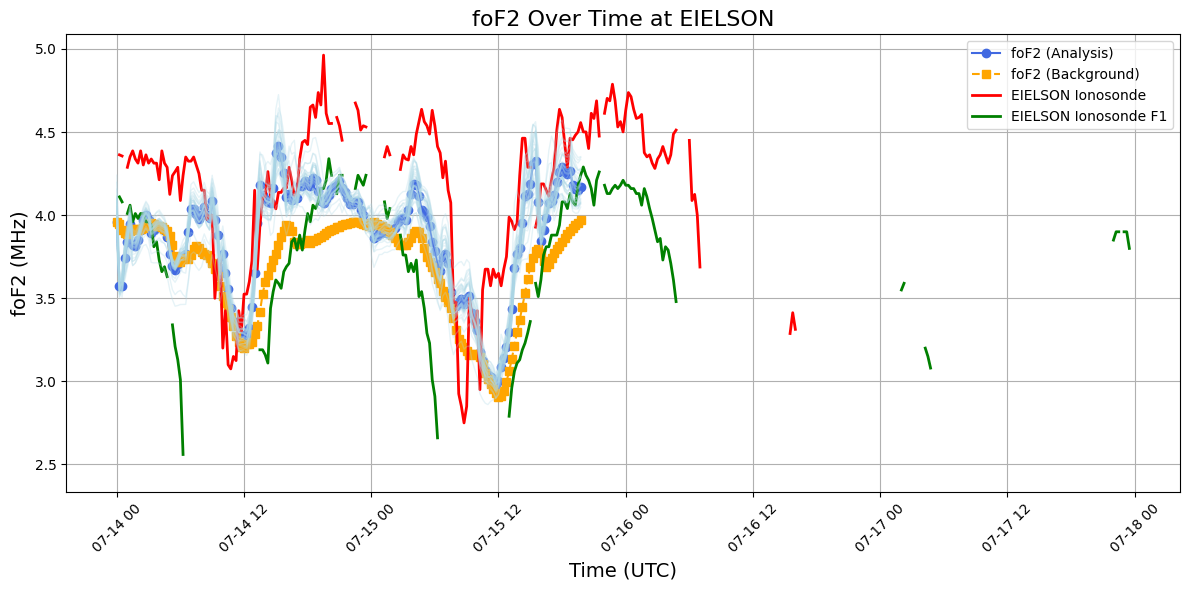

In [45]:
plot_fof2_for_station(cov_1_5_F107_6_scale_3x_std_dev_Ti_Te_0_2_df_summary, ionosonde_files, columns)


In [24]:
import matplotlib.pyplot as plt
import os
import pandas as pd

def plot_hmf2_for_station(df_summary, ionosonde_files, columns):
    """
    Plot hmF2 for model analysis, background, ensemble members, and optionally ionosonde data.

    Parameters:
    - df_summary: DataFrame with model hmF2 data
    - ionosonde_files: list of ionosonde data file paths
    - columns: column names for ionosonde data file
    """
    
    station_name_input = input("Enter the name of the station you want to plot (e.g., FAIRFORD): ").upper()

    df_station = df_summary[df_summary["Station"] == station_name_input]

    if df_station.empty:
        print(f"No model data found for station: {station_name_input}")
        return

    df_analysis = df_station[df_station["Source"] == "Analysis Mean"]
    df_background = df_station[df_station["Source"] == "Background Mean"]

    # Plot
    plt.figure(figsize=(12, 6))

    # Main model lines
    plt.plot(df_analysis["Datetime"], df_analysis["hmF2 (km)"], marker="o", linestyle="-", color="royalblue", label="hmF2 (Analysis)")
    plt.plot(df_background["Datetime"], df_background["hmF2 (km)"], marker="s", linestyle="--", color="orange", label="hmF2 (Background)")

    # Ionsonde overlay
    matching_files = [file for file in ionosonde_files if station_name_input.lower() in os.path.basename(file).lower()]
    if not matching_files:
        print(f"No ionosonde file found for {station_name_input}")
    else:
        file_path = matching_files[0]
        print(f"Loading ionosonde data from {file_path}...")
        df = pd.read_csv(
            file_path,
            sep=r"\s+",
            names=columns,
            header=1,
            na_values=["---"]
        )
        df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%Y.%m.%d %H:%M:%S", errors="coerce")
        df.set_index("datetime", inplace=True)
        plt.plot(df.index, df["hmF2"], label=f"{station_name_input} Ionosonde", color="red", linewidth=2)
        plt.plot(df.index, df["hmF1"], label = f"{station_name_input} Ionosonde F1", color = "green", linewidth =2)

    # Ensemble members
    for i in range(32):
        member_label = f"Member {i}"
        df_member = df_station[df_station["Source"] == member_label]
        plt.plot(df_member["Datetime"], df_member["hmF2 (km)"],
                 color='lightblue', linewidth=1, alpha=0.3)

    # Final styling
    plt.title(f"hmF2 Over Time at {station_name_input}", fontsize=16)
    plt.xlabel("Time (UTC)", fontsize=14)
    plt.ylabel("hmF2 (km)", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save output
    output_dir = "cov_1_5_F107_6_scale_3x_std_dev_Ti_Te_0_2_hmf2_plots"
    os.makedirs(output_dir, exist_ok=True)
    filename = f"{station_name_input}_hmf2_plot.png"
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")
    plt.show()


Enter the name of the station you want to plot (e.g., FAIRFORD):  eielson


Loading ionosonde data from /rds/projects/t/themendr-j-brown/aeneas_2.0/July2017Storm_Ionosonde_data/Eielson.txt...
Plot saved to cov_1_5_F107_6_scale_3x_std_dev_Ti_Te_0_2_hmf2_plots/EIELSON_hmf2_plot.png


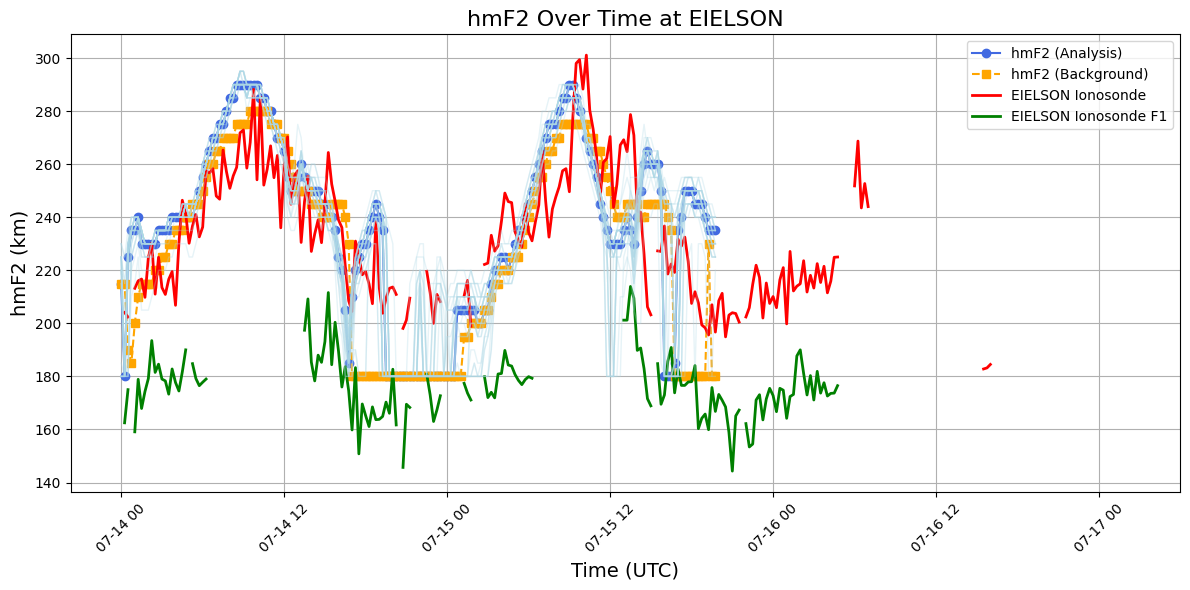

In [32]:
plot_hmf2_for_station(cov_1_5_F107_6_scale_3x_std_dev_Ti_Te_0_2_df_summary, ionosonde_files, columns)
